In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from statannotations.Annotator import Annotator
palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='white', font='CMU Serif', rc={'font.size':12, 'mathtext.fontset': 'cm'})
from matplotlib.ticker import FormatStrFormatter

# Sort the human data, eliminate non-learners

In [62]:
data = pd.read_pickle("human_data.pkl")
len(data['ID'].unique())

220

In [64]:
thr_slope = 0.1
thr_p = 0.1
yes, maybe, no = [], [], []
for i, ID in enumerate(data['ID'].unique()):
    D1 = data.query('ID==@ID and player=="investor"')
    res1 = scipy.stats.linregress(D1['game'], D1['coins'])
    if res1.slope>thr_slope and res1.pvalue < thr_p: yes.append(ID)
    elif res1.pvalue < thr_p: maybe.append(ID)
    else: no.append(ID)
print('yes', len(yes))
print('maybe', len(maybe))
print('no', len(no))
np.savez(f"data/human_yes_IDs.npz", yes=np.array(yes))
np.savez(f"data/human_maybe_IDs.npz", maybe=np.array(maybe))
np.savez(f"data/human_no_IDs.npz", no=np.array(no))

yes 80
maybe 46
no 94


# Plot individual learning trajectories

In [69]:
xs = np.arange(0, 15, 1)
yN = 11
yN2 = 6
ys = np.linspace(0, 1, yN2)
yes = np.load("data/human_yes_IDs.npz")['yes']
maybe = np.load("data/human_maybe_IDs.npz")['maybe']
no = np.load("data/human_no_IDs.npz")['no']

for i, ID in enumerate(data['ID'].unique()):
    if ID in yes: label='yes'
    if ID in maybe: label='maybe'
    if ID in no: label='no'
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((6.38, 2)))
    D1 = data.query('ID==@ID and player=="investor"')
    D2 = data.query('ID==@ID and player=="trustee"')
    opponent = D1['opponent'].unique()[0]
    sns.histplot(data=D1, x='game', y='generosity', bins=(15, yN), binrange=((0, 15),(0, 1)), ax=axes[0], color=palette[0])
    sns.histplot(data=D2, x='game', y='generosity', bins=(15, yN), binrange=((0, 15),(0, 1)), ax=axes[1], color=palette[1])
    ax = axes[0].twinx()
    ax2 = axes[1].twinx()
    res1 = scipy.stats.linregress(D1['game'], D1['coins'])
    res2 = scipy.stats.linregress(D2['game'], D2['coins'])
    sns.lineplot(data=D1, x='game', y='coins', ax=ax, color=palette[0])
    sns.lineplot(data=D2, x='game', y='coins', ax=ax2, color=palette[1])
    axes[0].set(ylabel="Generosity", title=f'participant vs. {opponent} trustee \n s={res1.slope:.2}, r={res1.rvalue:.2}, p={res1.pvalue:.2}', xticks=xs, xlim=((0, 14)), yticks=ys, ylim=((min(ys), max(ys))))
    axes[1].set(ylabel=None, title=f'participant vs. {opponent} investor \n s={res2.slope:.2}, r={res2.rvalue:.2}, p={res2.pvalue:.2}', xticks=xs, xlim=((0, 14)), yticks=ys, ylim=((min(ys), max(ys))))
    axes[0].set(ylabel="Generosity", xticks=xs, xlim=((0, 14)), yticks=ys, ylim=((min(ys), max(ys))))
    axes[1].set(ylabel=None, xticks=xs, xlim=((0, 14)), yticks=ys, ylim=((min(ys), max(ys))))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.set(ylabel=None)
    ax2.set(ylabel='Score')
    plt.tight_layout()
    fig.savefig(f"plots/human/{label}/{ID}_LT.png", dpi=600, bbox_inches='tight', pad_inches=0.02)
    plt.close('all')

# Remove all 'maybe' and 'no' learners

In [65]:
data = data.query("ID in @yes")
print('proself', len(data.query("orientation=='proself'")['ID'].unique()))
print('prosocial', len(data.query("orientation=='prosocial'")['ID'].unique()))
data.to_pickle("data/human_data_cleaned.pkl")

proself 33
prosocial 39


# Plot generosity distributions from final games

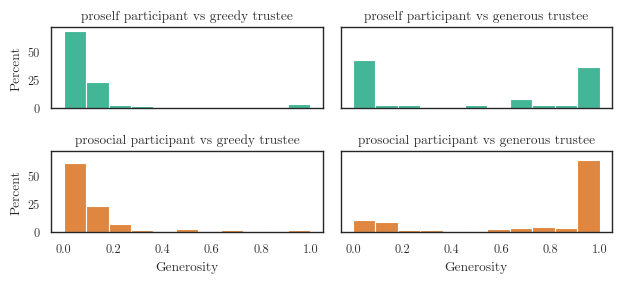

In [55]:
nFinal = 3
yN = 11

gameFinal = 14 - nFinal
D1 = data.query('player=="investor" & orientation=="proself" & opponent=="greedy" & game>@gameFinal')
D2 = data.query('player=="investor" & orientation=="prosocial" & opponent=="greedy" & game>@gameFinal')
D3 = data.query('player=="investor" & orientation=="proself" & opponent=="generous" & game>@gameFinal')
D4 = data.query('player=="investor" & orientation=="prosocial" & opponent=="generous" & game>@gameFinal')

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=((6.38, 3)))
sns.histplot(data=D1, x='generosity', bins=yN, binrange=(0, 1), ax=axes[0][0], color=palette[2], stat='percent')
sns.histplot(data=D2, x='generosity', bins=yN, binrange=(0, 1), ax=axes[1][0], color=palette[3], stat='percent')
sns.histplot(data=D3, x='generosity', bins=yN, binrange=(0, 1), ax=axes[0][1], color=palette[2], stat='percent')
sns.histplot(data=D4, x='generosity', bins=yN, binrange=(0, 1), ax=axes[1][1], color=palette[3], stat='percent')
axes[0][0].set(title='proself participant vs greedy trustee')
axes[1][0].set(title='prosocial participant vs greedy trustee', xlabel="Generosity")
axes[0][1].set(title='proself participant vs generous trustee')
axes[1][1].set(title='prosocial participant vs generous trustee', xlabel="Generosity")
plt.tight_layout()
fig.savefig("plots/emp_investor.png", dpi=600)

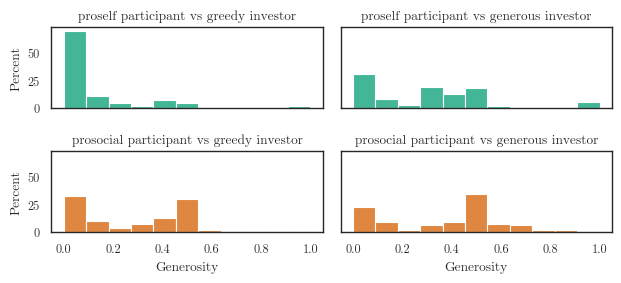

In [56]:
nFinal = 3
yN = 11

gameFinal = 14 - nFinal
D1 = data.query('player=="trustee" & orientation=="proself" & opponent=="greedy" & game>@gameFinal')
D2 = data.query('player=="trustee" & orientation=="prosocial" & opponent=="greedy" & game>@gameFinal')
D3 = data.query('player=="trustee" & orientation=="proself" & opponent=="generous" & game>@gameFinal')
D4 = data.query('player=="trustee" & orientation=="prosocial" & opponent=="generous" & game>@gameFinal')

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=((6.38, 3)))
sns.histplot(data=D1, x='generosity', bins=yN, binrange=(0, 1), ax=axes[0][0], color=palette[2], stat='percent')
sns.histplot(data=D2, x='generosity', bins=yN, binrange=(0, 1), ax=axes[1][0], color=palette[3], stat='percent')
sns.histplot(data=D3, x='generosity', bins=yN, binrange=(0, 1), ax=axes[0][1], color=palette[2], stat='percent')
sns.histplot(data=D4, x='generosity', bins=yN, binrange=(0, 1), ax=axes[1][1], color=palette[3], stat='percent')
axes[0][0].set(title='proself participant vs greedy investor')
axes[1][0].set(title='prosocial participant vs greedy investor', xlabel="Generosity")
axes[0][1].set(title='proself participant vs generous investor')
axes[1][1].set(title='prosocial participant vs generous investor', xlabel="Generosity")
plt.tight_layout()
fig.savefig("plots/emp_trustee.png", dpi=600)

## T-tests

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:3.526e-01 t=-9.302e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:5.268e-10 t=-6.361e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:1.161e-20 t=-9.640e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test indepe

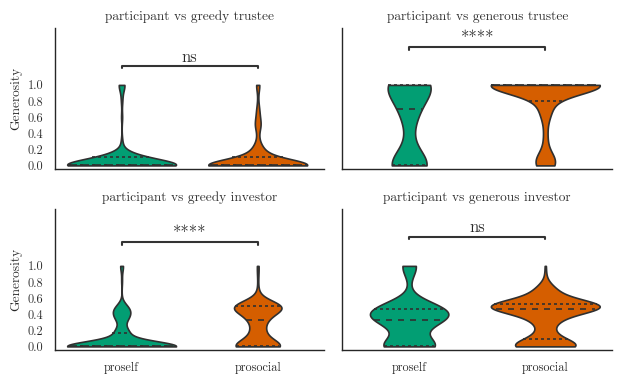

In [66]:
nFinal = 3
gameFinal = 14 - nFinal
D1 = data.query('player=="investor" & opponent=="greedy" & game>@gameFinal')
D2 = data.query('player=="investor" & opponent=="generous" & game>@gameFinal')
D3 = data.query('player=="trustee" & opponent=="greedy" & game>@gameFinal')
D4 = data.query('player=="trustee" & opponent=="generous" & game>@gameFinal')

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=((6.38, 4)))
sns.violinplot(data=D1, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[0][0], palette=palette[2:4], saturation=1, inner='quartile', cut=0)
annot = Annotator(pairs=[("proself", "prosocial")], data=D1, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[0][0], plot='violinplot')
annot.configure(test="t-test_ind", loc='inside').apply_test().annotate()
axes[0][0].set(xlabel=None, ylabel='Generosity', title='participant vs greedy trustee', yticks=((0, 0.2, 0.4, 0.6, 0.8, 1.0)))

sns.violinplot(data=D2, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[0][1], palette=palette[2:4], saturation=1, inner='quartile', cut=0)
annot = Annotator(pairs=[("proself", "prosocial")], data=D2, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[0][1], plot='violinplot')
annot.configure(test="t-test_ind", loc='inside').apply_test().annotate()
axes[0][1].set(xlabel=None, ylabel=None, title='participant vs generous trustee', yticks=((0, 0.2, 0.4, 0.6, 0.8, 1.0)))

sns.violinplot(data=D3, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[1][0], palette=palette[2:4], saturation=1, inner='quartile', cut=0)
annot = Annotator(pairs=[("proself", "prosocial")], data=D3, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[1][0], plot='violinplot')
annot.configure(test="t-test_ind", loc='inside').apply_test().annotate()
axes[1][0].set(xlabel=None, ylabel='Generosity', title='participant vs greedy investor', yticks=((0, 0.2, 0.4, 0.6, 0.8, 1.0)))

sns.violinplot(data=D4, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[1][1], palette=palette[2:4], saturation=1, inner='quartile', cut=0)
annot = Annotator(pairs=[("proself", "prosocial")], data=D4, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[1][1], plot='violinplot')
annot.configure(test="t-test_ind", loc='inside').apply_test().annotate()
axes[1][1].set(xlabel=None, ylabel=None, title='participant vs generous investor', yticks=((0, 0.2, 0.4, 0.6, 0.8, 1.0)))

sns.despine(fig=fig, ax=axes, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.tight_layout()
fig.savefig("plots/emp_Ttest_generosity.png", dpi=600)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:5.015e-02 t=1.962e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:8.190e-07 t=-5.006e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:6.515e-07 t=5.024e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independ

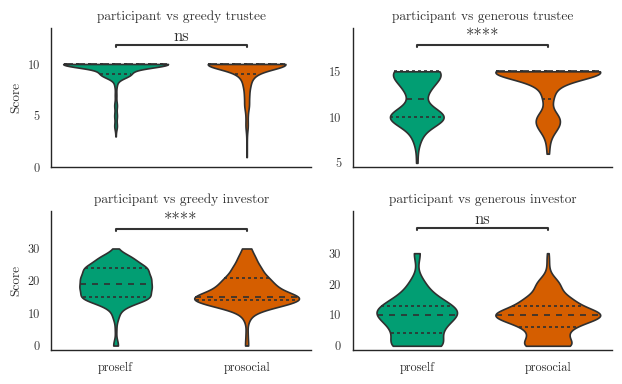

In [67]:
nFinal = 3
gameFinal = 14 - nFinal
D1 = data.query('player=="investor" & opponent=="greedy" & game>@gameFinal')
D2 = data.query('player=="investor" & opponent=="generous" & game>@gameFinal')
D3 = data.query('player=="trustee" & opponent=="greedy" & game>@gameFinal')
D4 = data.query('player=="trustee" & opponent=="generous" & game>@gameFinal')

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False, figsize=((6.38, 4)))
sns.violinplot(data=D1, x="orientation", y="coins", order=["proself", "prosocial"], ax=axes[0][0], palette=palette[2:4], saturation=1, inner='quartile', cut=0)
annot = Annotator(pairs=[("proself", "prosocial")], data=D1, x='orientation', y='coins', order=["proself", "prosocial"], ax=axes[0][0], plot='violinplot')
annot.configure(test="t-test_ind", loc='inside').apply_test().annotate()
axes[0][0].set(xlabel=None, ylabel='Score', title='participant vs greedy trustee', yticks=((0, 5, 10)))

sns.violinplot(data=D2, x="orientation", y="coins", order=["proself", "prosocial"], ax=axes[0][1], palette=palette[2:4], saturation=1, inner='quartile', cut=0)
annot = Annotator(pairs=[("proself", "prosocial")], data=D2, x='orientation', y='coins', order=["proself", "prosocial"], ax=axes[0][1], plot='violinplot')
annot.configure(test="t-test_ind", loc='inside').apply_test().annotate()
axes[0][1].set(xlabel=None, ylabel=None, title='participant vs generous trustee', yticks=((5, 10, 15)))

sns.violinplot(data=D3, x="orientation", y="coins", order=["proself", "prosocial"], ax=axes[1][0], palette=palette[2:4], saturation=1, inner='quartile', cut=0)
annot = Annotator(pairs=[("proself", "prosocial")], data=D3, x='orientation', y='coins', order=["proself", "prosocial"], ax=axes[1][0], plot='violinplot')
annot.configure(test="t-test_ind", loc='inside').apply_test().annotate()
axes[1][0].set(xlabel=None, ylabel='Score', title='participant vs greedy investor', yticks=(0, 10, 20, 30))

sns.violinplot(data=D4, x="orientation", y="coins", order=["proself", "prosocial"], ax=axes[1][1], palette=palette[2:4], saturation=1, inner='quartile', cut=0)
annot = Annotator(pairs=[("proself", "prosocial")], data=D4, x='orientation', y='coins', order=["proself", "prosocial"], ax=axes[1][1], plot='violinplot')
annot.configure(test="t-test_ind", loc='inside').apply_test().annotate()
axes[1][1].set(xlabel=None, ylabel=None, title='participant vs generous investor', yticks=((0, 10, 20, 30)))

sns.despine(fig=fig, ax=axes, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.tight_layout()
fig.savefig("plots/emp_Ttest_score.png", dpi=600)

# Late Defection

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:8.938e-05 t=-4.044e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:6.892e-02 t=-1.853e+00


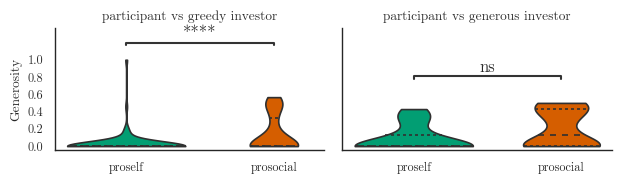

In [68]:
nFinal = 3
gameFinal = 14 - nFinal
D3 = data.query('player=="trustee" & opponent=="greedy" & game>@gameFinal & turn==4')
D4 = data.query('player=="trustee" & opponent=="generous" & game>@gameFinal & turn==4')

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=((6.38, 2)))
sns.violinplot(data=D3, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[0], palette=palette[2:4], saturation=1, inner='quartile', cut=0)
annot = Annotator(pairs=[("proself", "prosocial")], data=D3, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[0], plot='violinplot')
annot.configure(test="t-test_ind", loc='inside').apply_test().annotate()
axes[0].set(xlabel=None, ylabel='Generosity', title='participant vs greedy investor', yticks=((0, 0.2, 0.4, 0.6, 0.8, 1.0)))

sns.violinplot(data=D4, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[1], palette=palette[2:4], saturation=1, inner='quartile', cut=0)
annot = Annotator(pairs=[("proself", "prosocial")], data=D4, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[1], plot='violinplot')
annot.configure(test="t-test_ind", loc='inside').apply_test().annotate()
axes[1].set(xlabel=None, ylabel=None, title='participant vs generous investor', yticks=((0, 0.2, 0.4, 0.6, 0.8, 1.0)))

sns.despine(fig=fig, ax=axes, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.tight_layout()
fig.savefig("plots/emp_Ttest_latedefection.png", dpi=600)

In [4]:
player = 'investor'
opponent = 'greedy'
emp = pd.read_pickle("data/human_data_cleaned.pkl").query('player==@player & opponent==@opponent')

In [6]:
print(len(emp['ID'].unique()))

47


In [7]:
print(len(emp.query('orientation=="proself"')['ID'].unique()))

26


In [8]:
print(len(emp.query('orientation=="prosocial"')['ID'].unique()))

18


In [11]:
print(len(emp.query('orientation=="n/a"')['ID'].unique()))

3
